<a href="https://colab.research.google.com/github/wonjunchoi-arc/tensorflow1/blob/main/%ED%8F%AC%EC%9E%90%EB%9E%A9%EC%8A%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pathlib
import zipfile 
import os
import pandas as pd
import IPython
import collections
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import shape,math
from tensorflow.keras import Input,layers,Model
from tensorflow.keras.losses import mse,binary_crossentropy
from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#zip파일 압축해제
zipfile.ZipFile('/content/drive/MyDrive/wonjun/groove-v1.0.0-midionly.zip').extractall()

In [ ]:

#경로지정
data_root= '/content/groove' # 데이터 경로
csv_file = '/content/groove/info.csv' # midi파일의 session, id, bpm 정보를 담고있음.
tfrec_root = '/content/data_dir/music.tfrecord'# tfrecord파일 경로를 지정

In [ ]:
import pandas as pd
df = pd.read_csv('/content/groove/info.csv')
df = pd.DataFrame(df)
df.head(3)

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158,test
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test


**MIDI FILE의 이해 **
1bar는 악보에서의 한칸
1beat는 박자의 개념 최대 4박자까지 존재
1note 음표의 개념
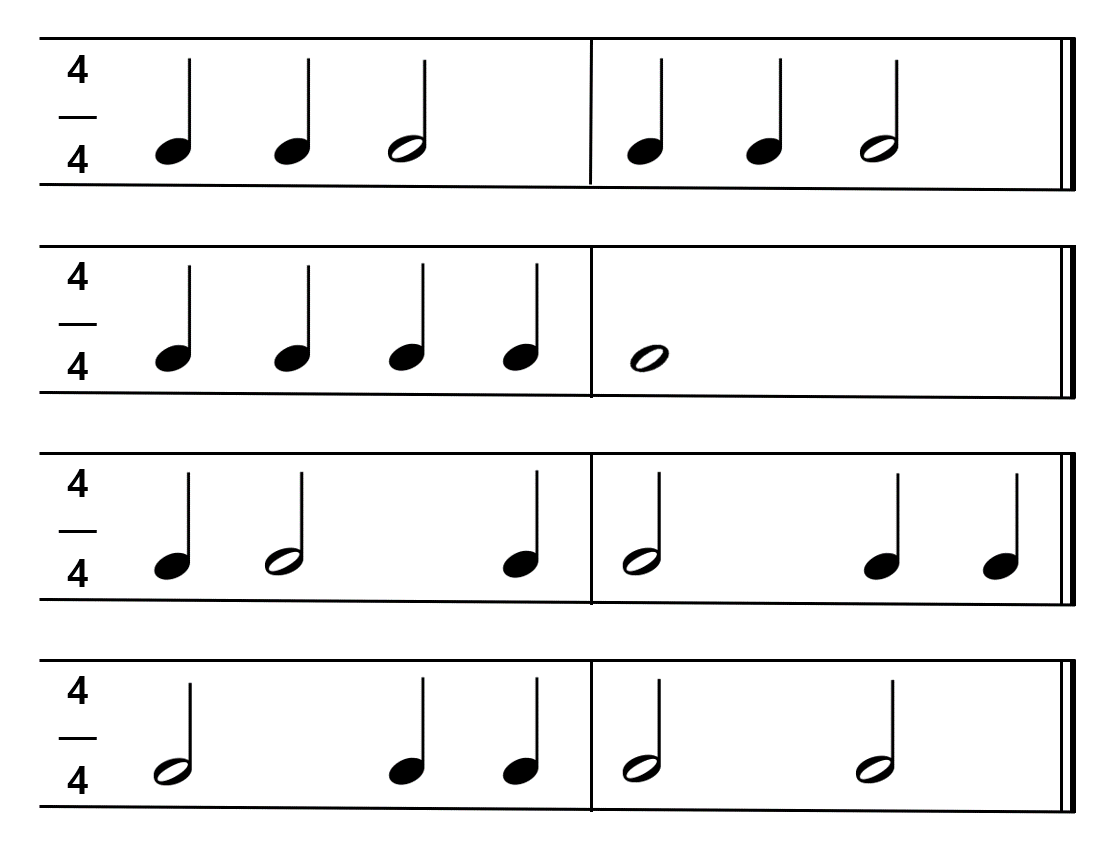

In [ ]:
!pip install note_seq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 63.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.8 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26099 sha256=df72342a962808a645f4f171bfe56ecd819ee5bac2080c19f30f115cda4658cf
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=d7b80a94c359a3343600976ad74e1920ef6ad606c42f8ee1

**MIDI형태의 파일을 벡터화하기 위해 github에서 발췌**

In [ ]:
import hashlib
import os

from note_seq import abc_parser
from note_seq import midi_io
from note_seq import musicxml_reader

import hashlib
import os

from note_seq import abc_parser
from note_seq import midi_io
from note_seq import musicxml_reader
import tensorflow.compat.v1 as tf

FLAGS = tf.app.flags.FLAGS

tf.app.flags.DEFINE_string('input_dir', None,
                           'Directory containing files to convert.')
tf.app.flags.DEFINE_string('output_file', None,
                           'Path to output TFRecord file. Will be overwritten '
                           'if it already exists.')
tf.app.flags.DEFINE_bool('recursive', False,
                         'Whether or not to recurse into subdirectories.')
tf.app.flags.DEFINE_string('log', 'INFO',
                           'The threshold for what messages will be logged '
                           'DEBUG, INFO, WARN, ERROR, or FATAL.')


def generate_note_sequence_id(filename, collection_name, source_type):
  """Generates a unique ID for a sequence.
  The format is:'/id/<type>/<collection name>/<hash>'.
  Args:
    filename: The string path to the source file relative to the root of the
        collection.
    collection_name: The collection from which the file comes.
    source_type: The source type as a string (e.g. "midi" or "abc").
  Returns:
    The generated sequence ID as a string.
  """
  filename_fingerprint = hashlib.sha1(filename.encode('utf-8'))
  return '/id/%s/%s/%s' % (
      source_type.lower(), collection_name, filename_fingerprint.hexdigest())


def convert_files(root_dir, sub_dir, writer, recursive=False):
  """Converts files.
  Args:
    root_dir: A string specifying a root directory.
    sub_dir: A string specifying a path to a directory under `root_dir` in which
        to convert contents.
    writer: A TFRecord writer
    recursive: A boolean specifying whether or not recursively convert files
        contained in subdirectories of the specified directory.
  Returns:
    A map from the resulting Futures to the file paths being converted.
  """
  dir_to_convert = os.path.join(root_dir, sub_dir)
  tf.logging.info("Converting files in '%s'.", dir_to_convert)
  files_in_dir = tf.gfile.ListDirectory(os.path.join(dir_to_convert))
  recurse_sub_dirs = []
  written_count = 0
  for file_in_dir in files_in_dir:
    tf.logging.log_every_n(tf.logging.INFO, '%d files converted.',
                           1000, written_count)
    full_file_path = os.path.join(dir_to_convert, file_in_dir)
    if (full_file_path.lower().endswith('.mid') or
        full_file_path.lower().endswith('.midi')):
      try:
        sequence = convert_midi(root_dir, sub_dir, full_file_path)
      except Exception as exc:  # pylint: disable=broad-except
        tf.logging.fatal('%r generated an exception: %s', full_file_path, exc)
        continue
      if sequence:
        writer.write(sequence.SerializeToString())
    elif (full_file_path.lower().endswith('.xml') or
          full_file_path.lower().endswith('.mxl')):
      try:
        sequence = convert_musicxml(root_dir, sub_dir, full_file_path)
      except Exception as exc:  # pylint: disable=broad-except
        tf.logging.fatal('%r generated an exception: %s', full_file_path, exc)
        continue
      if sequence:
        writer.write(sequence.SerializeToString())
    elif full_file_path.lower().endswith('.abc'):
      try:
        sequences = convert_abc(root_dir, sub_dir, full_file_path)
      except Exception as exc:  # pylint: disable=broad-except
        tf.logging.fatal('%r generated an exception: %s', full_file_path, exc)
        continue
      if sequences:
        for sequence in sequences:
          writer.write(sequence.SerializeToString())
    else:
      if recursive and tf.gfile.IsDirectory(full_file_path):
        recurse_sub_dirs.append(os.path.join(sub_dir, file_in_dir))
      else:
        tf.logging.warning(
            'Unable to find a converter for file %s', full_file_path)

  for recurse_sub_dir in recurse_sub_dirs:
    convert_files(root_dir, recurse_sub_dir, writer, recursive)


def convert_midi(root_dir, sub_dir, full_file_path):
  """Converts a midi file to a sequence proto.
  Args:
    root_dir: A string specifying the root directory for the files being
        converted.
    sub_dir: The directory being converted currently.
    full_file_path: the full path to the file to convert.
  Returns:
    Either a NoteSequence proto or None if the file could not be converted.
  """
  try:
    sequence = midi_io.midi_to_sequence_proto(
        tf.gfile.GFile(full_file_path, 'rb').read())
  except midi_io.MIDIConversionError as e:
    tf.logging.warning(
        'Could not parse MIDI file %s. It will be skipped. Error was: %s',
        full_file_path, e)
    return None
  sequence.collection_name = os.path.basename(root_dir)
  sequence.filename = os.path.join(sub_dir, os.path.basename(full_file_path))
  sequence.id = generate_note_sequence_id(
      sequence.filename, sequence.collection_name, 'midi')
  tf.logging.info('Converted MIDI file %s.', full_file_path)
  return sequence


def convert_musicxml(root_dir, sub_dir, full_file_path):
  """Converts a musicxml file to a sequence proto.
  Args:
    root_dir: A string specifying the root directory for the files being
        converted.
    sub_dir: The directory being converted currently.
    full_file_path: the full path to the file to convert.
  Returns:
    Either a NoteSequence proto or None if the file could not be converted.
  """
  try:
    sequence = musicxml_reader.musicxml_file_to_sequence_proto(full_file_path)
  except musicxml_reader.MusicXMLConversionError as e:
    tf.logging.warning(
        'Could not parse MusicXML file %s. It will be skipped. Error was: %s',
        full_file_path, e)
    return None
  sequence.collection_name = os.path.basename(root_dir)
  sequence.filename = os.path.join(sub_dir, os.path.basename(full_file_path))
  sequence.id = generate_note_sequence_id(
      sequence.filename, sequence.collection_name, 'musicxml')
  tf.logging.info('Converted MusicXML file %s.', full_file_path)
  return sequence


def convert_abc(root_dir, sub_dir, full_file_path):
  """Converts an abc file to a sequence proto.
  Args:
    root_dir: A string specifying the root directory for the files being
        converted.
    sub_dir: The directory being converted currently.
    full_file_path: the full path to the file to convert.
  Returns:
    Either a NoteSequence proto or None if the file could not be converted.
  """
  try:
    tunes, exceptions = abc_parser.parse_abc_tunebook(
        tf.gfile.GFile(full_file_path, 'rb').read())
  except abc_parser.ABCParseError as e:
    tf.logging.warning(
        'Could not parse ABC file %s. It will be skipped. Error was: %s',
        full_file_path, e)
    return None

  for exception in exceptions:
    tf.logging.warning(
        'Could not parse tune in ABC file %s. It will be skipped. Error was: '
        '%s', full_file_path, exception)

  sequences = []
  for idx, tune in tunes.items():
    tune.collection_name = os.path.basename(root_dir)
    tune.filename = os.path.join(sub_dir, os.path.basename(full_file_path))
    tune.id = generate_note_sequence_id(
        '{}_{}'.format(tune.filename, idx), tune.collection_name, 'abc')
    sequences.append(tune)
    tf.logging.info('Converted ABC file %s.', full_file_path)
  return sequences


def convert_directory(root_dir, output_file, recursive=False):
  """Converts files to NoteSequences and writes to `output_file`.
  Input files found in `root_dir` are converted to NoteSequence protos with the
  basename of `root_dir` as the collection_name, and the relative path to the
  file from `root_dir` as the filename. If `recursive` is true, recursively
  converts any subdirectories of the specified directory.
  Args:
    root_dir: A string specifying a root directory.
    output_file: Path to TFRecord file to write results to.
    recursive: A boolean specifying whether or not recursively convert files
        contained in subdirectories of the specified directory.
  """
  with tf.io.TFRecordWriter(output_file) as writer:
    convert_files(root_dir, '', writer, recursive)


def main(unused_argv):
  tf.logging.set_verbosity(FLAGS.log)

  if not FLAGS.input_dir:
    tf.logging.fatal('--input_dir required')
    return
  if not FLAGS.output_file:
    tf.logging.fatal('--output_file required')
    return

  input_dir = os.path.expanduser(FLAGS.input_dir)
  output_file = os.path.expanduser(FLAGS.output_file)
  output_dir = os.path.dirname(output_file)

  if output_dir:
    tf.gfile.MakeDirs(output_dir)



In [ ]:
convert_directory(data_root,tfrec_root,recursive=True) #전처리 함수 Tfrecord파일 생성


**Tfrecord파일 dataset으로 전환**

**Modeling**

In [ ]:
import tensorflow as tf


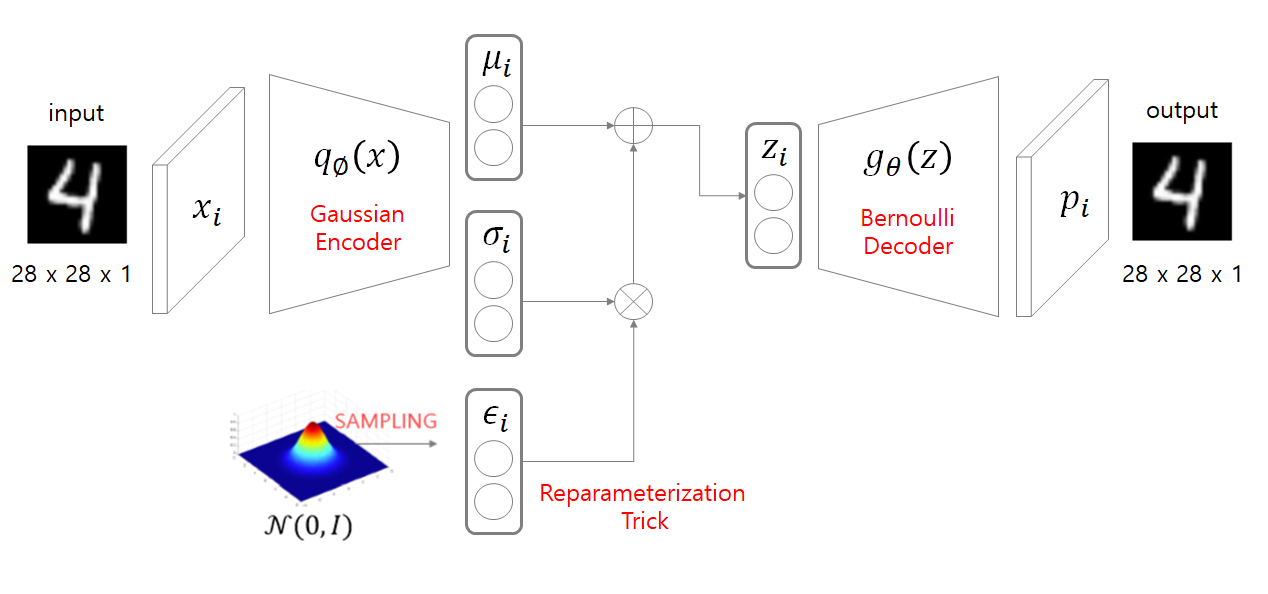

**MUSIC VAE의 기초가 되는 VAE 모델을 바탕으로 구현**



**ENCODER**

In [ ]:
def encoder():
  # 주어진 데이터로 모델의 실험을 할 수 없어 가상의 데이터를 만들어 실험
  input = torch.randn(512, 256, 4)
  input_fw= tf.transpose(input,[1,0,2])
#LSTM의 마지막 hidden state의 output값을 가져오기 위한 code
  def _get_final_index(sequence_length, time_major=True):
    indices = [tf.maximum(0, sequence_length - 1),
              tf.range(sequence_length.shape[0])]
    if not time_major:
      indices = indices[-1::-1]

    return tf.stack(indices, axis=1)
  def get_final(sequence, sequence_length, time_major=True):
    final_index = _get_final_index(sequence_length, time_major)
    return tf.gather_nd(sequence, final_index)

  # 두개층의 단방향 LSTM을 2pair로 만들어서 1pair은 정방향의 vector값을 생성, 나머지 하나는 역방향의 vector값을 생성
  lstm_fw1 = tf.keras.layers.LSTM(units=2048,return_sequences=True)
  lstm_fw2 = tf.keras.layers.LSTM(units=2048,return_sequences=True)
  lstm_bw1 = tf.keras.layers.LSTM(units=2048,return_sequences=True)
  lstm_bw2 = tf.keras.layers.LSTM(units=2048,return_sequences=True)

#정방향 output
  x = lstm_fw1(input_fw)
  output_fw = lstm_fw2(x)

#역방향 output을 위해 sequence 형태를 반전시킴
  seq_lengths = tf.fill([512], 256) #reverse_sequence의 tensor값을 위한 변형
  input_bw = tf.reverse_sequence(input_fw, seq_lengths,seq_axis=0, batch_axis=1)
  x = lstm_bw1(input_bw)
  output_bw = lstm_bw2(x)
  
  last_h_fw = get_final(output_fw, seq_lengths) # 정방향 LSTM의 마지막 hiiden state값을 취함  [1X 512 X 4 ] 
  last_h_bw = output_bw[0] #이미 역방향으로 뒤집혀 있어 가장 앞의 값을 취함                   [1X 512 X 4 ] 

  sum_fw_bw = tf.concat([last_h_fw,last_h_bw],1) #[1X 1024 X 4 ] 



  z_mean = tf.keras.layers.Dense(sum_fw_bw,512,kernel_initializer=tf.random_normal_initializer)  # 인코도에 인풋을 넣고  나온값을 평균으로
  z_log_var = tf.keras.layers.Dense(sum_fw_bw,512,activation=tf.nn.softplus,kernel_initializer=tf.random_normal_initializer) # 인코도에 인풋을 넣고 나온값을 표준편차로


  # Z 샘플링 함수 생성  Reparameterization trick 을 위해 즉  인코더의 아웃풋으로 나오는 평균과 표준 편차로 정규분포를 만들고 해당 정규 분포를 Z로 Decoder의 입력으로 사용할 경우 backpropa가 되자 않기 때문에 해당 트릭 사용
  # 아웃풋인 평균과 표준편차에  
  def sampling(args):
      z_mean, z_log_var = args
      batch = shape(z_mean)[0]
      dim = shape(z_mean)[1]

      # by default, random_normal has mean = 0 and std = 1.0
      # Reparameterization Trick사용을 위해 Gussian(=normal)분포에서 랜덤변수(sample) ε추출 
      epsilon = tf.compat.v2.random.normal(shape=(batch, dim))
      return z_mean + tf.math.exp(0.5 * z_log_var) * epsilon

  #  layers.Lambda API 래핑에 사용할 함수와, 유닛수(n,)를 지정합니다.
  z_sampling = layers.Lambda(sampling, (2,), name='z_sample')([z_mean, z_log_var])

  return Model(input,[z_mean,z_log_var,z_sampling], name='encoder')


encoder = encoder()

# 인코더 네트워크를 확인합니다.
encoder.summary()

plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

In [ ]:
def decoder():
  
  

  return 

decoder = decoder()

# 디코더의 네트워크 확인.
decoder.summary()
plot_model(decoder, to_file='music_vae.png', show_shapes=True)

In [ ]:
def music_vae():
  return

#VAE 모델 정의
model = music_vae()

#모델 네트워크 확인 
model.summary()
plot_model(model,to_file='music_vae.png',show_shapes=True)